# Visualize results, local splicing

## Summary of results

In [1]:
load('../../_m/leafviz.RData')
levels(meta$group) <- c("Female", "Male")
sample_table
cluster_summary
intron_summary

group,count
<chr>,<int>
F,114
M,246


Results,n
<chr>,<int>
Number of differentially spliced clusters at FDR = 0.05,303
Fully annotated,153
Contain unannotated junctions,150


Results,n
<chr>,<int>
Number of fully annotated junctions,1100
Number of junctions with cryptic 5' splice site,120
Number of junctions with cryptic 3' splice site,131
Number of junctions with two cryptic splice sites,43
Number of novel junctions that connect two annotated splice sites,96


In [2]:
clusters['gene'] <- gsub("</i>", "", gsub("<i>", "", clusters$gene))
head(clusters)

,clusterID,N,coord,gene,annotation,FDR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
303,clu_755_-,3,chrX:53217966-53220839,KDM5C,annotated,2.56e-43
301,clu_744_-,10,chrX:53176622-53193437,KDM5C,cryptic,5.78e-41
62,clu_118466_-,7,chr12:81281432-81294835,PPFIA2,cryptic,1.34e-16
294,clu_61504_+,3,chrX:47199106-47199480,UBA1,cryptic,4.89e-16
199,clu_21090_-,11,chr3:197066754-197081051,DLG1,cryptic,2.86e-13
248,clu_143938_-,22,chr6:130863718-130885096,EPB41L2,cryptic,5.34e-13


In [3]:
write.table(clusters, file="cluster_ds_results_annotated.txt", sep="\t", quote=FALSE, row.names=FALSE)

## Generate plots

### Load Libraries

In [4]:
library(tidyverse)
library(ggplot2)
library(DT)
library(leafcutter)
library(reshape2)
library(gridExtra)
library(intervals) # needed for pretty strand arrow placement
library(foreach)
library(grid)
library(gtable)
library(ggrepel)

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Rcpp


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'intervals'


The following object is masked from 'package:purrr':

    reduce


The following object is masked from 'package:tidyr':

    expand



Attaching package: 'foreach'


The following objects ar

### Define functions

In [5]:
filter_intron_table <- function(introns, clu){
    d <- introns %>% filter(clusterID == clu) %>% 
        select(chr, start, end, verdict, deltapsi) %>%
        arrange(desc(abs(deltapsi))) %>%
        rename("dPSI" = deltapsi)
    row.names(d) <- letters[1:nrow(d)] # letters is just a:z
    return(d)
}


getGeneLength <- function(gene_name, exons_table){
    exons      <- exons_table[ exons_table$gene_name == gene_name, ]
    geneStart  <- min(exons$start)
    geneEnd    <- max(exons$end)
    geneLength <- geneEnd - geneStart
    if( geneLength >1e6){
        pixels <- 5000
    } else if ( geneLength > 5e5 & geneLength < 1e6){
        pixels <- 3000
    } else if ( geneLength > 1.5e5 & geneLength <= 5e5){
        pixels <- 2000
    } else {
        stopifnot(geneLength <= 1.5e5)
        pixels <- "auto"
    }
    return(pixels)
}


select_data <- function(sel, clusters, exons_table){
    gene <- clusters[ sel, ]$gene
    width <- getGeneLength(gene, exons_table)
    clusterID <- clusters[ sel, ]$clusterID
    coord <- clusters[ sel, ]$coord
    return(list(gene = gene, width = width, cluster = clusterID, coord = coord))
}


get_mytable <- function(mydata){
    # make table theme
    tableTheme <- ttheme_minimal(
        core=list(bg_params=list(fill=c("whitesmoke","white"), col=NA)),
        colhead=list(fg_params=list(col="black", fontface="bold"), 
                     bg_params=list(fill="white")),
        rowhead=list(fg_params=list(col="black"),
                     bg_params=list(fill=c("white", "whitesmoke"))))
    ## get table and format it
    mytable <- tableGrob(filter_intron_table(introns, mydata$cluster), 
                         theme=tableTheme)
    mycols <- ncol(mytable)
    mytable$widths <- unit( c( 1/(3*mycols), rep(1/mycols, mycols-1) ), "npc")
    mytable <- gtable_add_grob(mytable, 
                               grobs=segmentsGrob(x0 = unit(0,"npc"),
                                                  y0 = unit(0,"npc"),
                                                  x1 = unit(1,"npc"),
                                                  y1 = unit(0,"npc"),
                                                  gp = gpar(lwd = 2.0)),
                               t=2, b=nrow(mytable), l=1, r=mycols)
    mytable <- gtable_add_grob(mytable,
                               grobs=segmentsGrob(x0 = unit(0,"npc"),
                                                  y0 = unit(0,"npc"),
                                                  x1 = unit(1,"npc"),
                                                  y1 = unit(0,"npc"),
                                                  gp = gpar(lwd = 2.0)),
                               t = 1, b = 1, l = 1, r = mycols)
    return(mytable)
}


### Plot top 6 clusters

In [6]:
save_plot <- function(fn, p, w, h){
    for(ext in c(".pdf", ".svg", ".png")){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

In [10]:
plot_cluster <- function(num, clusters, dir='./'){
    mydata = select_data(num, clusters, exons_table)
    while(mydata$gene == '.'){
        num = num+1
        mydata = select_data(num, clusters, exons_table)
    }
    mytable <- get_mytable(mydata)
    gene_name = mydata$gene
    plotTitle <- paste0(gene_name, '_', mydata$cluster)
    fn <- paste0(dir, plotTitle, '_top_',num)
    clusterPlot <- make_cluster_plot(mydata$cluster,
                                     main_title=plotTitle,
                                     meta=meta, 
                                     cluster_ids=cluster_ids,
                                     exons_table=exons_table,
                                     counts=counts, introns=introns)
    save_plot(fn, grid.arrange(clusterPlot, mytable, nrow=2), 10, 8)
    
    if (is.numeric(mydata$width)) {
        new_width = mydata$width / 100
    } else {
        new_width = as.numeric(mydata$width)
    }
    clusterPlot <- make_gene_plot(mydata$gene, counts=counts,
                                  introns=introns,
                                  exons_table=exons_table,
                                  cluster_list=clusters,
                                  clusterID=mydata$clusterID,
                                  introns_to_plot=introns_to_plot, 
                                  debug=F)
    fn = paste0(dir, gene_name, '_allClusters_top_',num)
    save_plot(fn, clusterPlot, new_width, 6)
}


## Plot splicing

Warning message in dir.create("top10"):
"'top10' already exists"
Warning message in plot_cluster(num, clusters, "top10/"):
"NAs introduced by coercion"
Saving 6.67 x 6 in image

Saving 6.67 x 6 in image

Saving 6.67 x 6 in image

Warning message in plot_cluster(num, clusters, "top10/"):
"NAs introduced by coercion"
Saving 6.67 x 6 in image

Saving 6.67 x 6 in image

Saving 6.67 x 6 in image



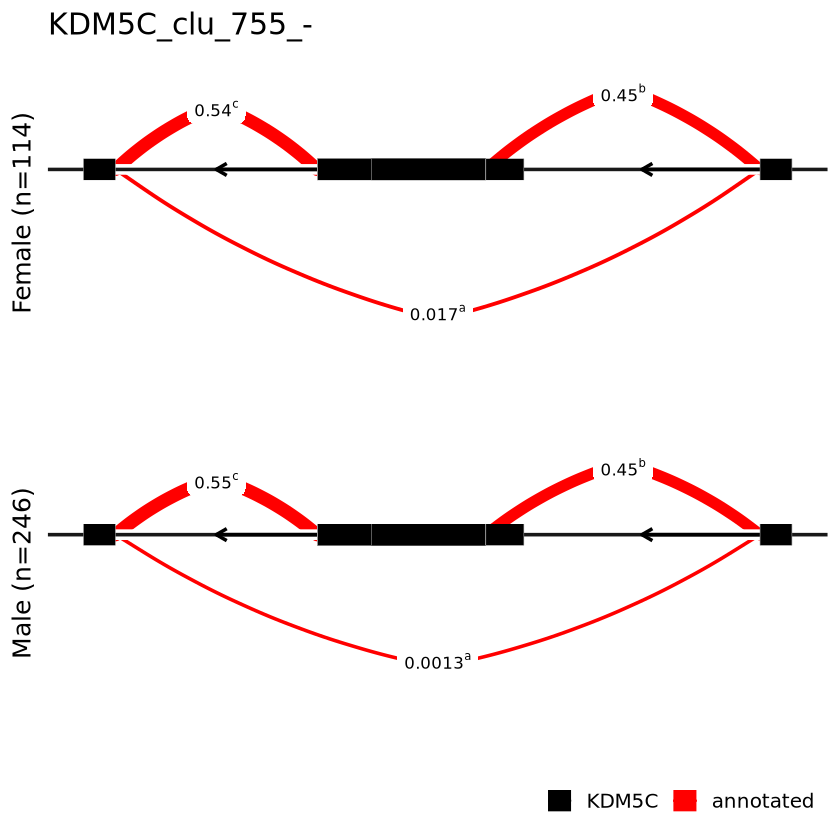

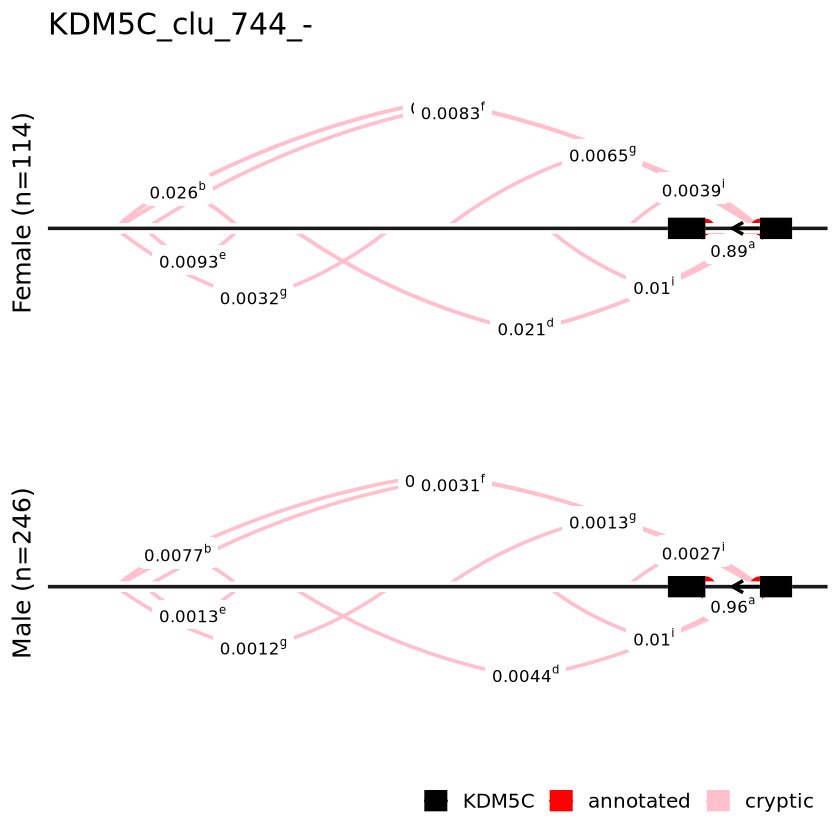

Warning message in plot_cluster(num, clusters, "top10/"):
"NAs introduced by coercion"
Saving 6.67 x 6 in image

Saving 6.67 x 6 in image

Saving 6.67 x 6 in image



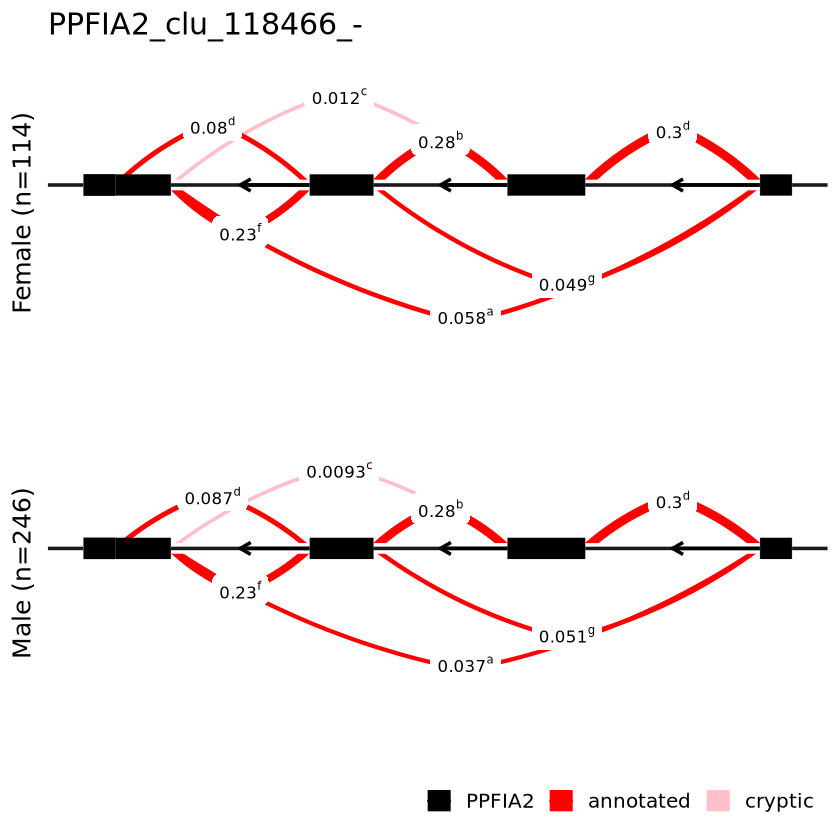

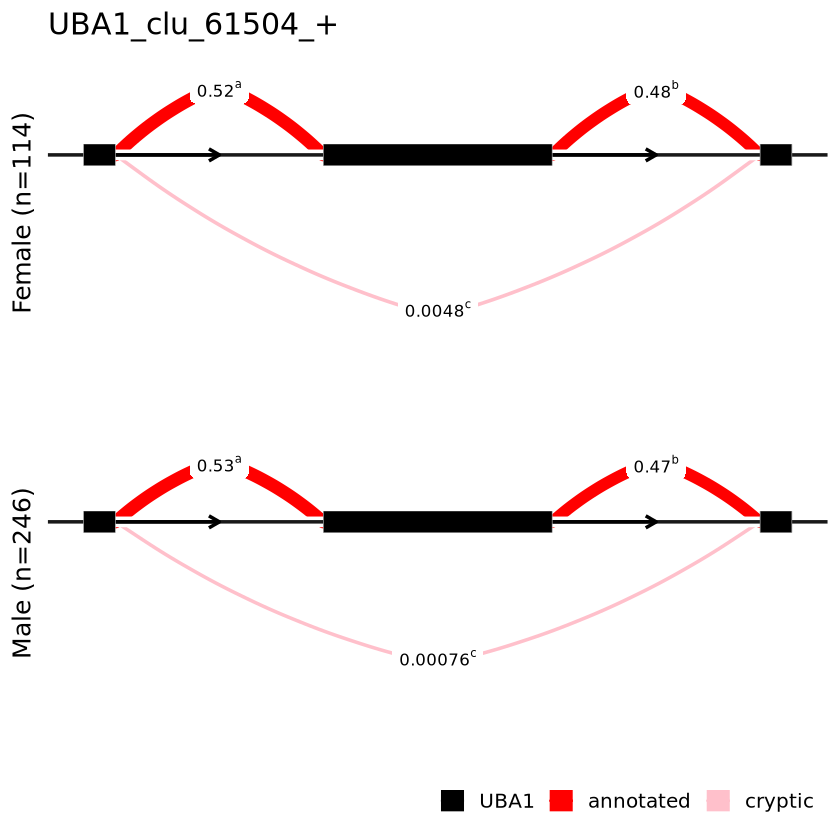

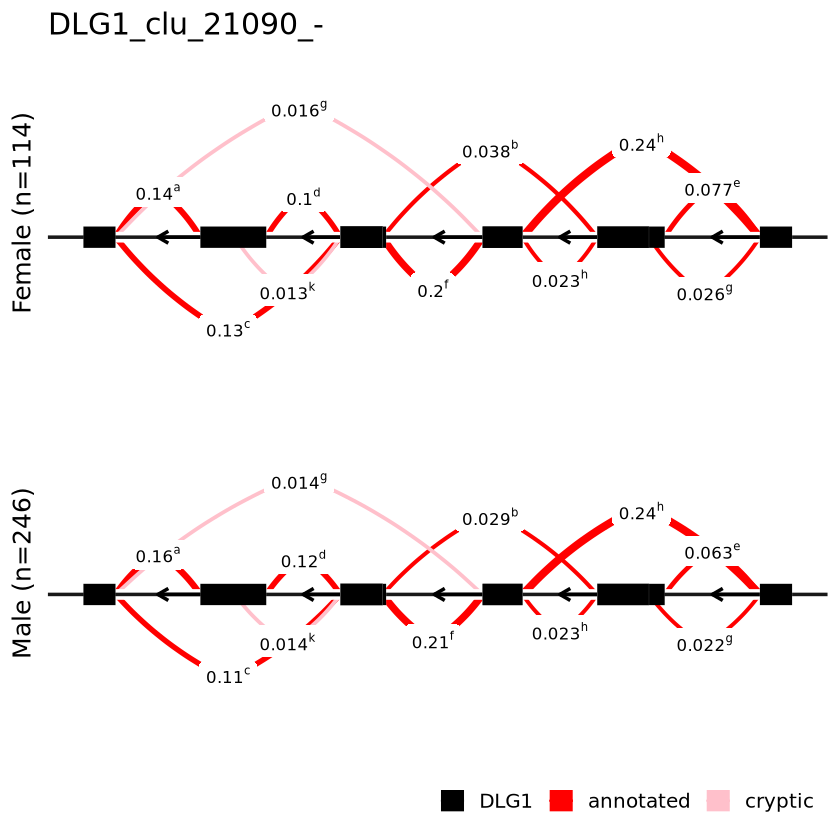

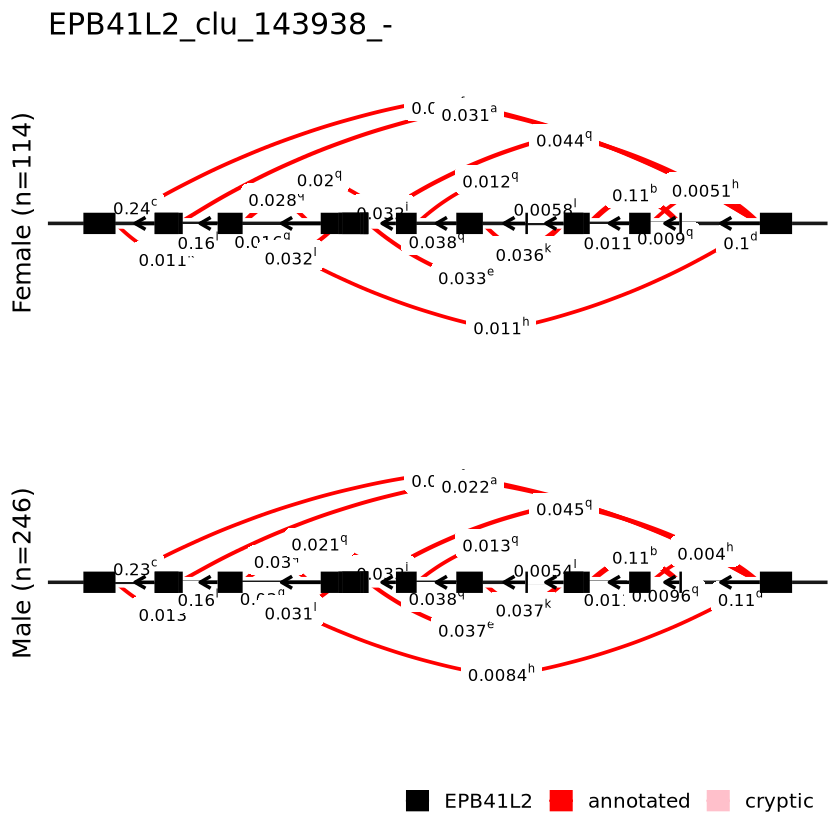

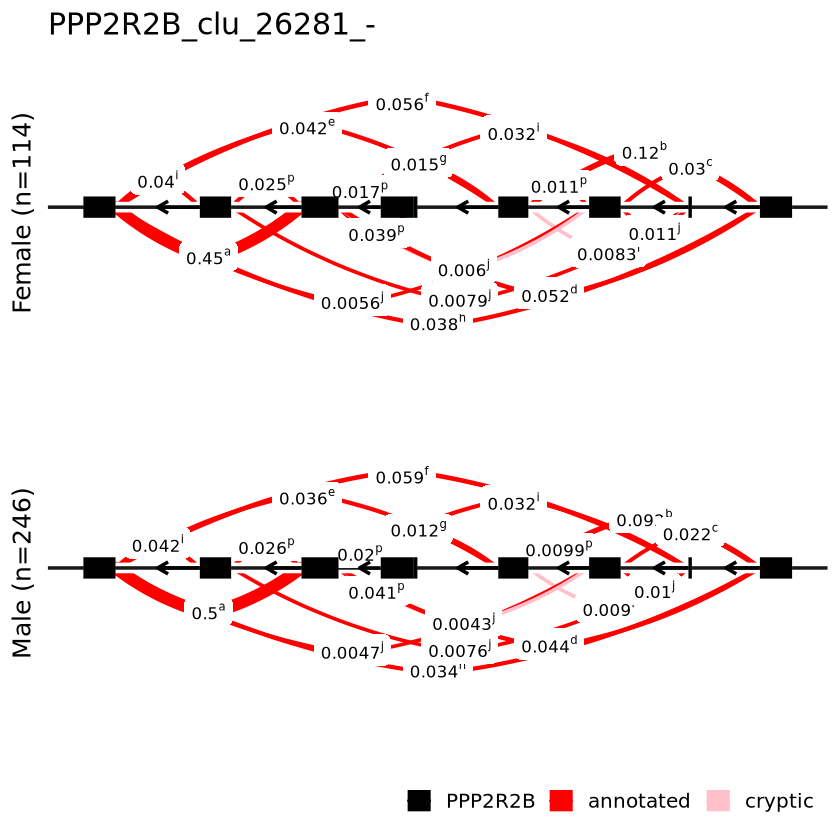

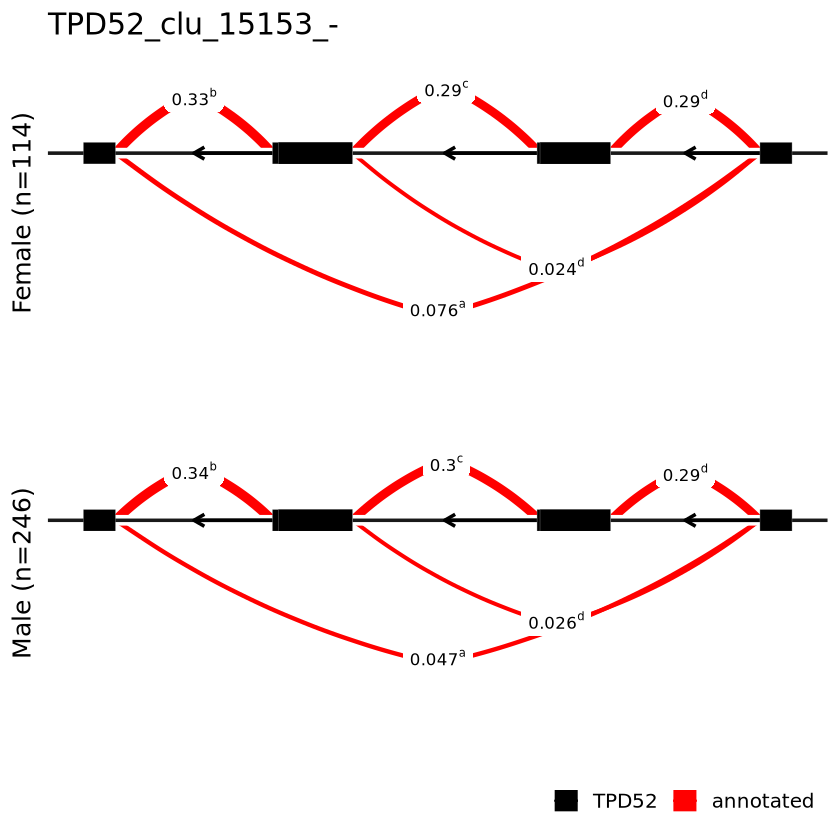

Warning message in plot_cluster(num, clusters, "top10/"):
"NAs introduced by coercion"
Saving 6.67 x 6 in image

Saving 6.67 x 6 in image

Saving 6.67 x 6 in image



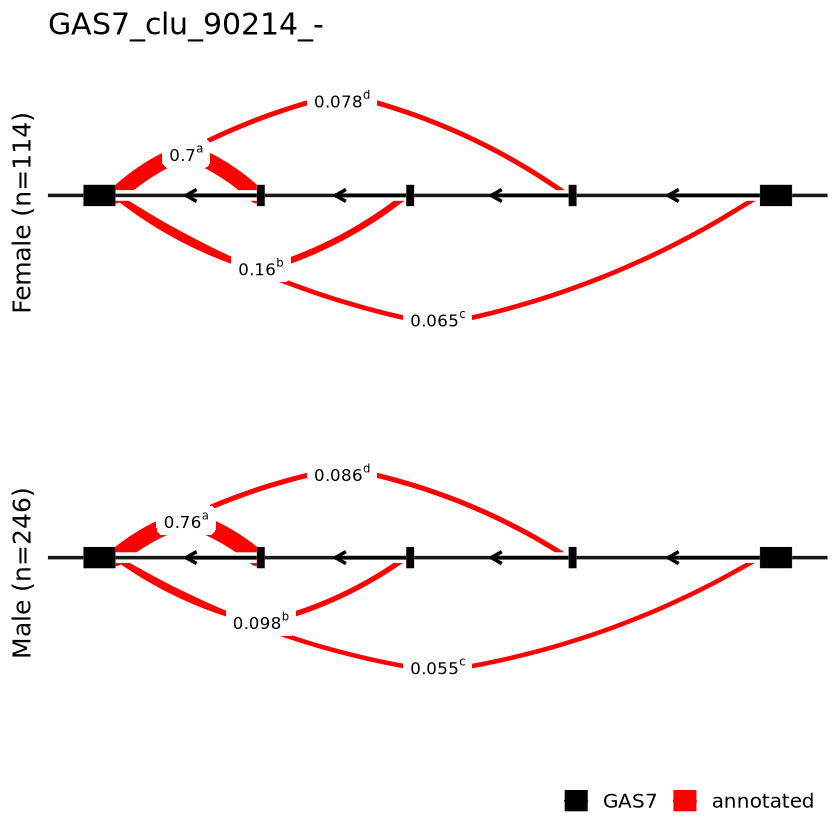

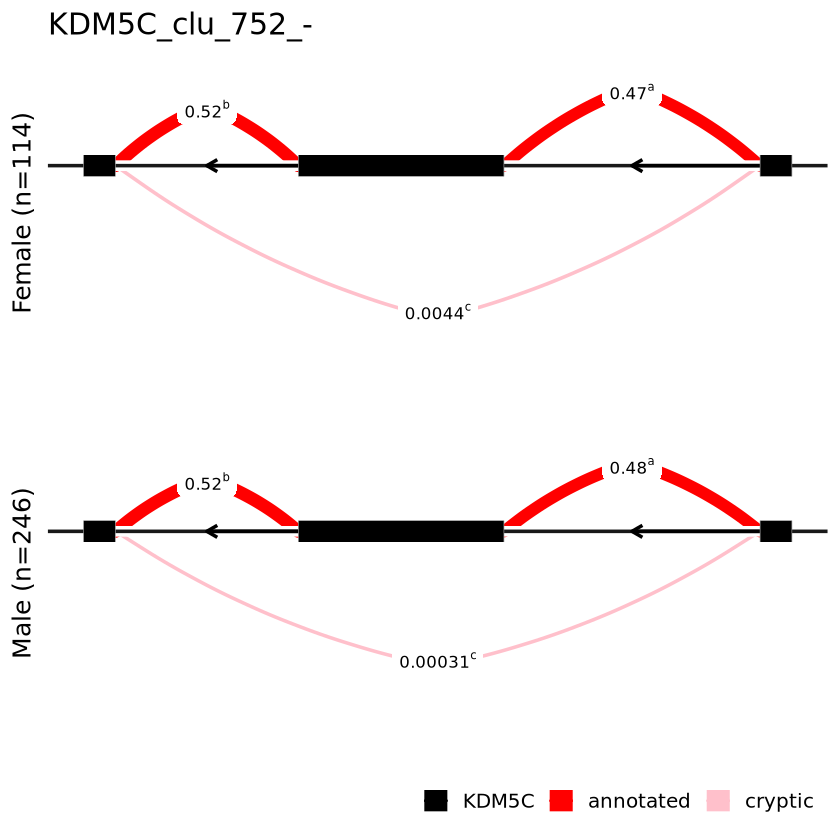

In [11]:
dir.create("top10")
for(num in 1:10){
    plot_cluster(num, clusters, "top10/")
}

In [22]:
dir.create("x_chromosome")
x_clu = clusters %>% filter(str_detect(coord, "chrX"), FDR < 0.05)

for(num in 1:dim(x_clu)[1]){
    plot_cluster(num, x_clu, "x_chromosome/")
}

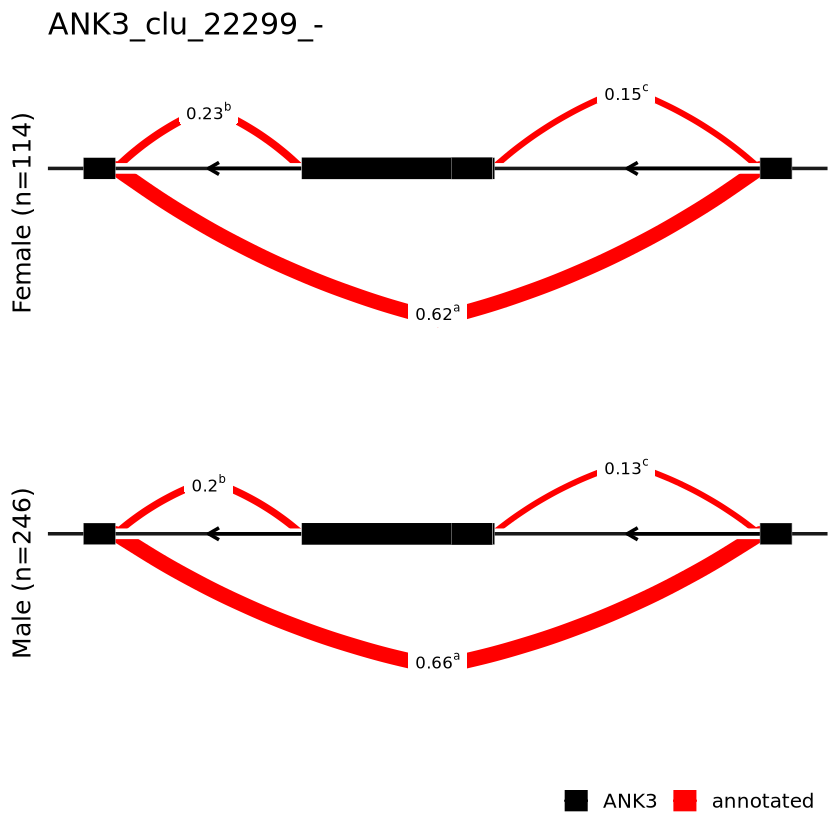

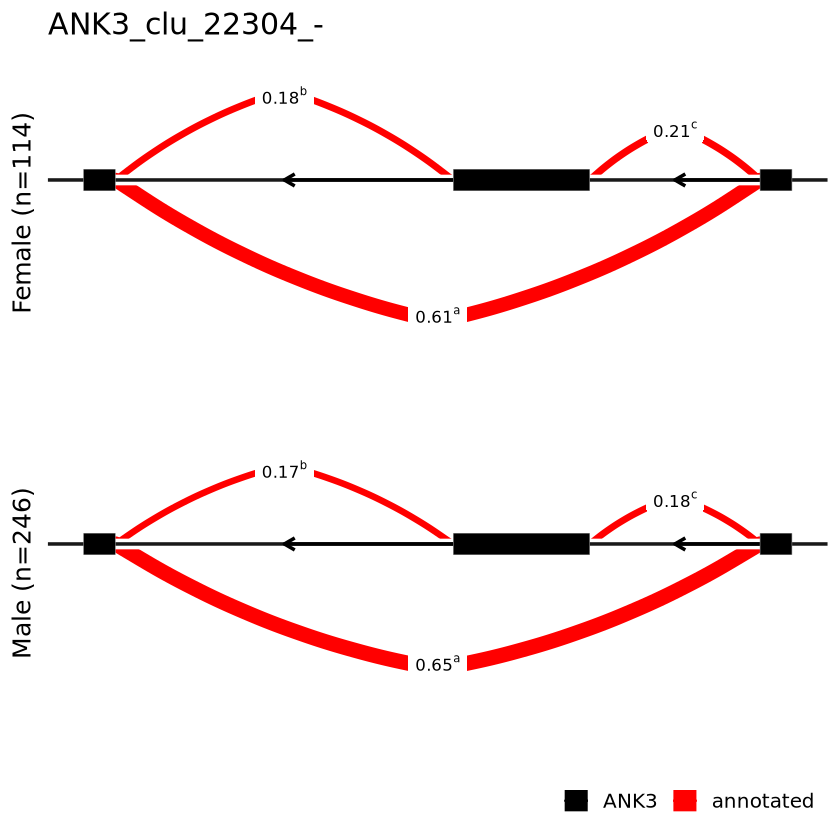

In [9]:
dir.create("ank3")
ank3 = clusters %>% filter(gene == 'ANK3')
for(num in 1:dim(ank3)[1]){
    plot_cluster(num, ank3, "ank3/")
}